**Question 3 - Modeling**

Uber’s Driver team is interested in predicting which driver signups are most likely to start driving. To help explore this question, we have provided a sample dataset of a cohort of driver signups. The data was pulled a some time after they signed up to include the result of whether they actually completed their first trip. It also includes several pieces of background information gathered about the driver and their car.<br>

We would like you to use this data set to help understand what factors are best at **predicting whether a signup will start to drive within 30 days of signing up**, and offer suggestions to operationalize those insights to help Uber.<br>

See below for a description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. Please also call out any data
related assumptions or issues that you encounter.

- [Part A](#Part_A)
 1. [Data Cleaning](#Part_A1)
 2. [Assigning Target Variable](#Part_A2)
 3. [Visualizaiton](#Part_A3)
   - [numeric variable visualization](#Part_A31)
   - [correlation heatmap visualization](#Part_A32)
   - [categorical variable visualization](#Part_A33)
 
 
- [Part B](#Part_B)

 1. [Data preprocessing](#Part_B1)
 2. [Model building](#Part_B2)
 3. [Parameter Tuning](#Part_B3)
 
 
- [Part C](#Part_C)


# Part A  <a id='Part_A'></a>

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver signups took a first trip within 30 days of signing up?

**Answer:**<br>
50.24 % of driver signup did not took a first trip within 30 days <br>
49.76 % of driver signup took the first trip with in 30 days 

In [1]:
# import library
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score

In [2]:
# read data set
df = pd.read_csv("product_ds_exercise_2018_h2_dataset.csv")

# check number of record
print("the data set have {} records".format(df.shape[0]))

# check target variable missing or not
print("number of missing signup_timestamp is {}".format(df["signup_timestamp"].isnull().sum()))

# drop the signup_tstp null, and check the record again
df = df[df["signup_timestamp"].notnull()]
print("the data set (after remove the missing signup_timestamp) have {} records".format(df.shape[0]))

the data set have 12357 records
number of missing signup_timestamp is 1163
the data set (after remove the missing signup_timestamp) have 11194 records


Since there are 1163 driver has missing signup timestamp, even we have other information in terms of this driver signup, we can not calculate or estimate whether this driver signup leads to a first competed trip within 30 days or not. I chose to delete these 1,163 records.

#### 1. Data Cleaning  <a id='Part_A1'></a>

In [3]:
# Data Cleaning #
# convert type(object) to type(date)
df["signup_timestamp"] = pd.to_datetime(df["signup_timestamp"])
df["bgc_date"] = pd.to_datetime(df["bgc_date"])
df["vehicle_added_date"] = pd.to_datetime(df["vehicle_added_date"])
df["first_completed_trip_timestamp"] = pd.to_datetime(df["first_completed_trip_timestamp"])

# creating "missing" for categorical variable
df['signup_os'] = np.where(df["signup_os"].notnull(), df["signup_os"], "missing")
df['signup_channel'] = np.where(df["signup_channel"].notnull(), df["signup_channel"], "missing")
df['vehicle_make'] = np.where(df["vehicle_make"].notnull(), df["vehicle_make"], "missing")

# create missing indicator for numeric varaible
df['bgc_date_known'] = df['bgc_date'].notnull()
df['vehicle_added_date_known'] = df['vehicle_added_date'].notnull()

#### 2. Assigning Target Variable  <a id='Part_A2'></a> 

In [4]:
# create the target varaible - took a first trip within 30 days of signing up 
df['signup2firsttrip_in30'] = np.where((df["first_completed_trip_timestamp"] - df["signup_timestamp"]).dt.days <= 30, 1, 0)
# check how many people start first trip with in 30 days
df['signup2firsttrip_in30'].value_counts()/df['signup2firsttrip_in30'].value_counts().sum()
# 1 means took the first trip within 30 days since signup, 
# 0 means did not complete the first trip within 30 days since signup

1    0.549312
0    0.450688
Name: signup2firsttrip_in30, dtype: float64

- Create 3-5 charts to help the Driver team visualize key patterns in the data. 
- Are there any patterns that appear to predict whether a signup will start to drive within 30 days of signing up?

#### 3. Visualization<a id='Part_A3'></a>

_**Visualization for numeric attribute**_  <a id='Part_A31'></a>

Take away from the following numeric variable distribution:<br>
- The distribution of vehicle year between the took and not take 1st trip group is very similar. Successfully complete the trip group's vehicle year is more recent than the not compete group.
- the distribution of signup to vehicle added date is a normal distribution for the "took the trip" group, centering at zero, means most drivers who took their 1st trip within 30 days add their vehicle on the signup day. In contrast, the "fail took the trip" group's distribution is much more spread out and has the fat right tail, meaning those drivers took a very long time to add their vehicle.
- the distribution of day from signup to driver agreed to pursue background check shows the "took the trip group" is overall quicker to consented than the "not took" group.

In [5]:
# feature engineering before model
# for date varaible
df["signup2bgc_m"] = (df["bgc_date"] - df["signup_timestamp"])/np.timedelta64(1,'m')
df["signup2vad_m"] = (df["vehicle_added_date"] - df["signup_timestamp"])/np.timedelta64(1,'m')

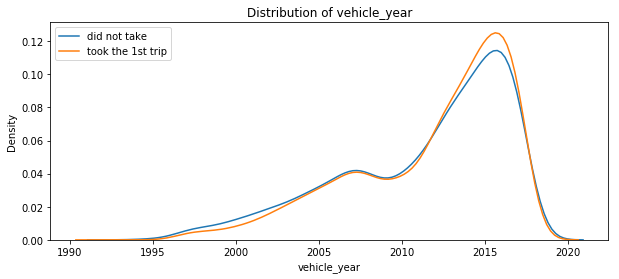

In [6]:
plt.figure(figsize = (10, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(df.loc[df['signup2firsttrip_in30'] == 0, 'vehicle_year'] , label = 'did not take')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['signup2firsttrip_in30'] == 1, 'vehicle_year'] , label = 'took the 1st trip')

# Labeling of plot
plt.xlabel('vehicle_year'); plt.ylabel('Density'); plt.title('Distribution of vehicle_year');

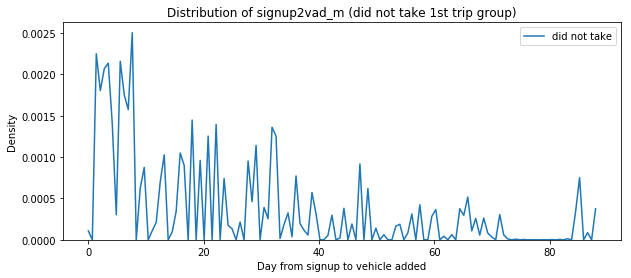

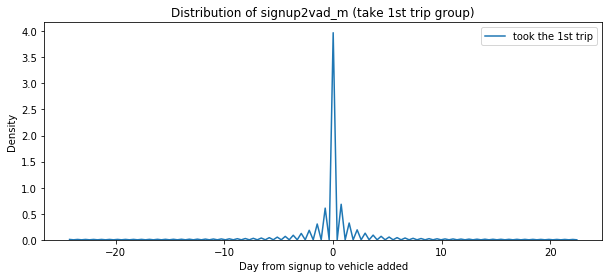

In [7]:
plt.figure(figsize = (10, 4))
plt.figure(1)

# KDE plot of loans that were repaid on time
sns.kdeplot(df.loc[df['signup2firsttrip_in30'] == 0, 'signup2vad_m']/(60*24) , label = 'did not take')

# Labeling of plot
plt.xlabel('Day from signup to vehicle added'); plt.ylabel('Density'); plt.title('Distribution of signup2vad_m (did not take 1st trip group)');

plt.figure(figsize = (10, 4))
plt.figure(2)

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['signup2firsttrip_in30'] == 1, 'signup2vad_m']/(60*24) , label = 'took the 1st trip')

# Labeling of plot
plt.xlabel('Day from signup to vehicle added'); plt.ylabel('Density'); plt.title('Distribution of signup2vad_m (take 1st trip group)');

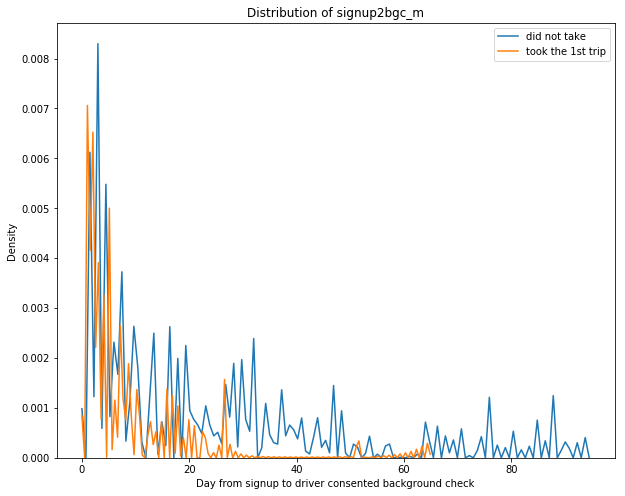

In [8]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df.loc[df['signup2firsttrip_in30'] == 0, 'signup2bgc_m']/(60*24) , label = 'did not take')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['signup2firsttrip_in30'] == 1, 'signup2bgc_m']/(60*24) , label = 'took the 1st trip')

# Labeling of plot
plt.xlabel('Day from signup to driver consented background check'); plt.ylabel('Density'); plt.title('Distribution of signup2bgc_m');

_** correlation between target variable and the numeric varaibles**_  <a id='Part_A32'></a>

Take away from the correlation result:<br>
- the day from signup to vehicle added date is highly correlated with the day from signup to driver agreed to pursue background check
- the days between signup to background check consent is most correlated to whether the driver is going to complete the first trip in 30 days, but the correlation is still limited.


In [9]:
# Extract the EXT_SOURCE variables and show correlations
corrs_data = df[['signup2firsttrip_in30', 'signup2bgc_m', 'signup2vad_m', 'vehicle_year']]
corrs_data = corrs_data.corr()
corrs_data

,signup2firsttrip_in30,signup2bgc_m,signup2vad_m,vehicle_year
signup2firsttrip_in30,1.000000,-0.110313,-0.081554,0.042088
signup2bgc_m,-0.110313,1.000000,0.494575,-0.020398
signup2vad_m,-0.081554,0.494575,1.000000,0.001794
vehicle_year,0.042088,-0.020398,0.001794,1.000000


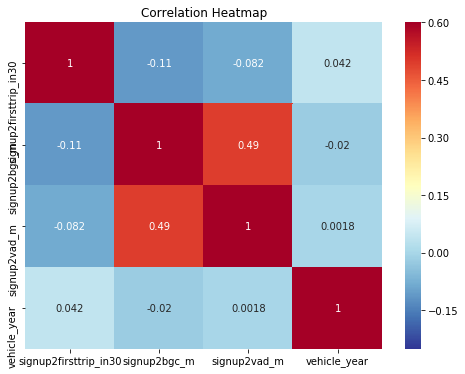

In [10]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(corrs_data, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

_**Visualization for categorical variable**_  <a id='Part_A33'></a>

Take away from the categorical attributes visualization:<br>
- the completion rate across city is very close.
- the completion rate across signup os, the ios_web shows the top completion rate 59.5%, while missing shows the lowest completion rate 51.6%.
- the completion rate across signup channel, the Referral shows the top completion rate 62%, while R2D shows the lowest completion rate 45%.
- the completion rate across vehicle make, the vehicle makes with top three competion rate are Acura, Kia, and Toyota
- the completion rate across vehicle model, the vehicle makes with top three competion rate are Sienna,Optima, Focus

In [11]:
# categorical varaible uniqure value
df.drop(['id'],axis = 1).select_dtypes('object').apply(pd.Series.nunique, axis = 0)

city_name           3
signup_os           6
signup_channel      6
vehicle_make       48
vehicle_model     473
dtype: int64

vehicle_model has 473 types, while the vehicle make has 47 types. These categorical value are way too much for us to generalize any useful information. So I decide to group an categorical variable less than 1%

In [12]:
# aggragate categorical value less than 1% in to group 'other'
def cat_other_ind(df,vat_var):
    var_tab = df[vat_var].value_counts()
    less_10 = var_tab[var_tab/var_tab.sum() < 0.01].index
    
    l = ('|').join(less_10)
    m = df[vat_var].str.contains(l)
    
    df[vat_var] = np.where(m, 'Other', df[vat_var])

cat_other_ind(df,"vehicle_make")
cat_other_ind(df,"vehicle_model")

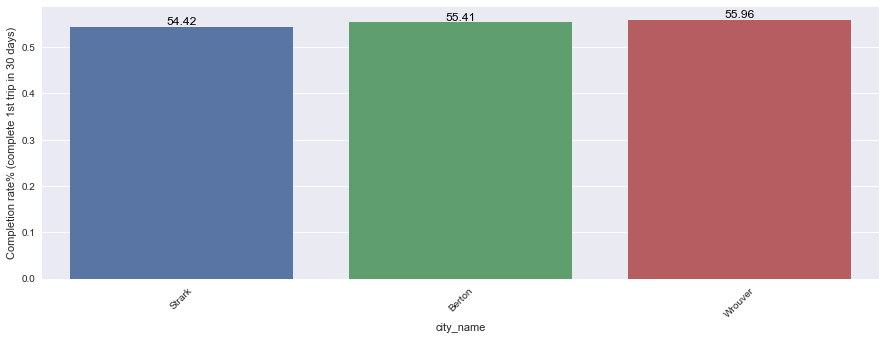

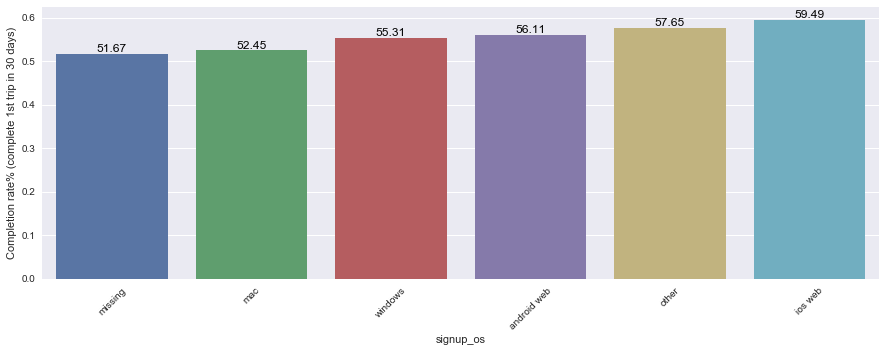

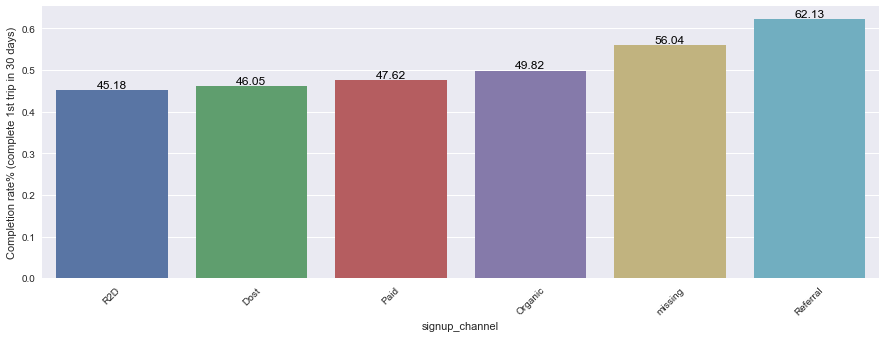

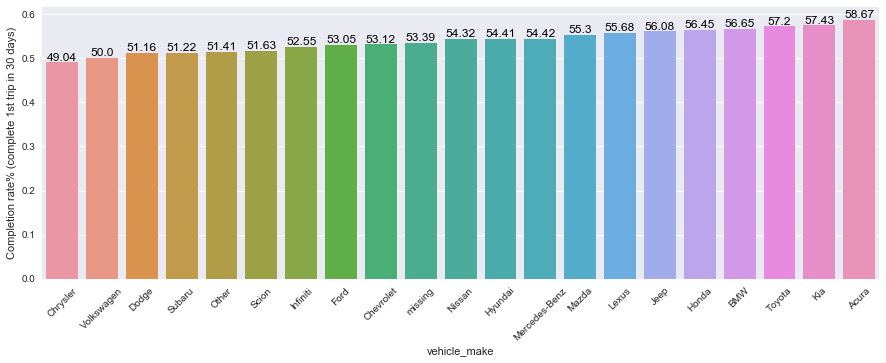

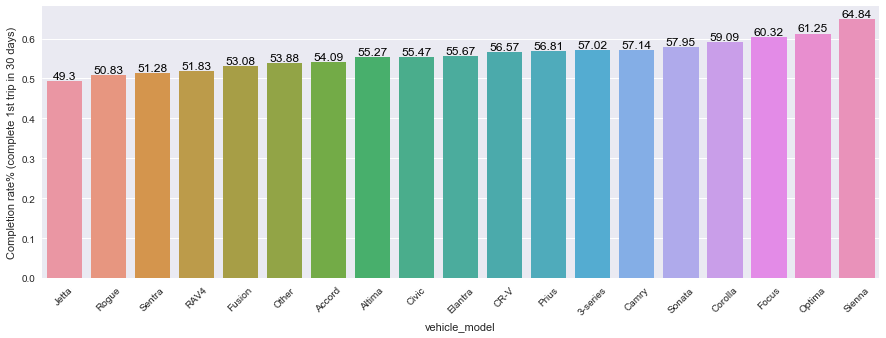

In [13]:
cat_var = df.drop(["id"],axis=1).select_dtypes('object').apply(pd.Series.nunique, axis = 0).index

# plot the bar plot
sns.set(rc={'figure.figsize':(15,5)})

for i, var in enumerate(cat_var):
    plt.figure(i)
    groupedvalues=df.groupby(var).mean().sort_values("signup2firsttrip_in30").reset_index()
    g=sns.barplot(x=var, y="signup2firsttrip_in30", data=groupedvalues, ci = None)
    for index, row in groupedvalues.iterrows():
        g.text(row.name,row.signup2firsttrip_in30,round(100 * row.signup2firsttrip_in30,2), color='black',ha='center', va='bottom')

        g.set_xticklabels(g.get_xticklabels(), rotation=45)
    
    # Labeling of plot
    plt.ylabel('Completion rate% (complete 1st trip in 30 days)');

# Part B  <a id='Part_B'></a>

Q1: Build a predictive model to help Uber determine whether or not a driver signup will start driving within 30 days of signing up. <br> 

**Answer:** I built a random forest model to predict the 1st drive completion within 30 days.

Q2: Discuss why you chose your approach, what alternatives you considered, and any concerns you have. <br>

**Answer:**  Since this is a binary classification task - to predict driver is going to complete 1st ride in 30 day (Yes/No), plenty of binary classification models can be utilized for prediction. I only explore three options (decision tree, random forest, and adaptive boosting). Other advanced models could leads to better result, but I limit the analysis in 4 hours so the advanced models are not incorporated here.

Since random forest leads the best testing auc score, compared with adaptive boosting and individual decision tree. so I chose random forest as my predictive model. To avoid overfitting, I use cross validation to measure my training set's performance.

Concern: 
- more advance parameter tuning should be conducted to leads better result.
- one drawback of random forest is its is slow during the prediction new instance


Q3: How valid is your model? Include any key indicators of model performance.<br>

**Answer:**  The performance metrics I choose is the auc, which is the area under the roc curve. the final testing auc score for the random forest is 60%. I also look at other evaluation in the confusion matix like accuracy, precision, recall.

#### 1. Data preprocessing <a id='Part_B1'></a>

In [14]:
# 1. Drop date variable (since intermediate vars are created)
df_feature = df.drop(["signup_timestamp","bgc_date","vehicle_added_date",
                      "first_completed_trip_timestamp","signup2firsttrip_in30"], axis = 1).set_index('id')
df_target = df["signup2firsttrip_in30"]

# 2. one-hot encoding of categorical variables
df_feature = pd.get_dummies(df_feature)
features = df_feature.columns.tolist()

# 3. Split test train set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_feature,df_target, test_size=0.2, random_state=42)

# 4. Imputation and Scaler

# Median imputation of missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')

# Scale each feature 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on the training data and transform both training and testing data
imputer.fit(X_train.values)
X_train = imputer.transform(X_train.values)
X_test = imputer.transform(X_test.values)

# Repeat with the scaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 5. pring the shape
print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (8955, 60)
Testing data shape:  (2239, 60)


#### 2. Built Models <a id='Part_B2'></a>

In [15]:
# baseline model - decision tree
# decisiton tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_train)

# training set performance
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree, X_train, y_train,
                         scoring="roc_auc", cv=10)
print('traing auc score:', scores.mean())

# testing set performance
y_pred = tree.predict(X_test)
print('testing auc score:', roc_auc_score(y_test,y_pred))

traing auc score: 0.5420257331955199
testing auc score: 0.5298625299634807


In [16]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500,max_features="auto")
rf.fit(X_train, y_train)

# training set performance
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train, y_train,
                         scoring="roc_auc", cv=10)
print('traing auc score:', scores.mean())

# testing set performance
y_pred = rf.predict(X_test)
print('testing auc score:', roc_auc_score(y_test,y_pred))

traing auc score: 0.5946368009036254
testing auc score: 0.5668567705400666


In [17]:
# adaptive boosting
from sklearn.ensemble import AdaBoostClassifier
adab = AdaBoostClassifier(n_estimators=500)
adab.fit(X_train, y_train)

# training set performance
from sklearn.model_selection import cross_val_score

scores = cross_val_score(adab, X_train, y_train,
                         scoring="roc_auc", cv=10)
print('traing auc score:', scores.mean())

# testing set performance
y_pred = adab.predict(X_test)
print('testing auc score:', roc_auc_score(y_test,y_pred))

traing auc score: 0.5748343624925976
testing auc score: 0.5525499123216268


#### 3. Parameter Tuning <a id='Part_B3'></a>

The random forest model leads the best testing auc score. Use Grid-Search for further prameter tuning.

In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [300, 400], 
               'max_features': [12,14,16]}]

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=10,
                           scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)
print("best parameter based on the toy grid search:",grid_search.best_params_)

best parameter based on the toy grid search: {'max_features': 16, 'n_estimators': 400}


In [20]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances_df = pd.DataFrame({'feature': features, 'importance': feature_importances})

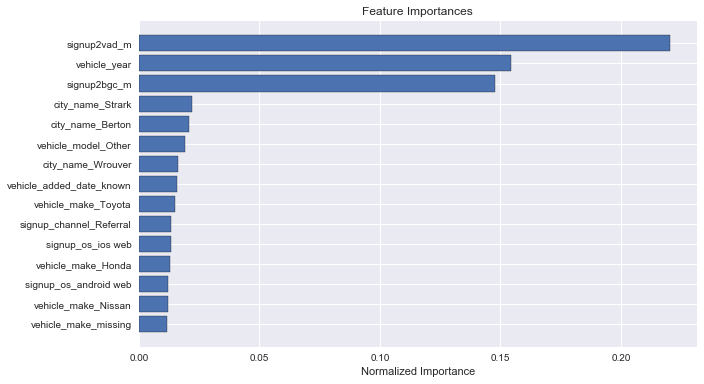

,index,feature,importance,importance_normalized
0,4,signup2vad_m,0.220508,0.220508
1,0,vehicle_year,0.154249,0.154249
2,3,signup2bgc_m,0.147668,0.147668
3,6,city_name_Strark,0.022217,0.022217
4,5,city_name_Berton,0.020814,0.020814
5,53,vehicle_model_Other,0.019330,0.019330
6,7,city_name_Wrouver,0.016172,0.016172
7,2,vehicle_added_date_known,0.015803,0.015803
8,38,vehicle_make_Toyota,0.015132,0.015132
9,18,signup_channel_Referral,0.013340,0.013340


In [21]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

plot_feature_importances(feature_importances_df)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.35      0.43      1019
           1       0.58      0.76      0.66      1220

   micro avg       0.57      0.57      0.57      2239
   macro avg       0.56      0.55      0.54      2239
weighted avg       0.56      0.57      0.55      2239



In [22]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.59968512563422 {'max_features': 12, 'n_estimators': 300}
0.6000215271723347 {'max_features': 12, 'n_estimators': 400}
0.6004121932505591 {'max_features': 14, 'n_estimators': 300}
0.600850117663838 {'max_features': 14, 'n_estimators': 400}
0.6014352614221801 {'max_features': 16, 'n_estimators': 300}
0.6025873958602485 {'max_features': 16, 'n_estimators': 400}


# Part C  <a id='Part_C'></a>

Hypothesize how Uber might leverage the insights gained from the data to generate more first trips (again, a few ideas/sentences will suffice).

**Answer:**

Based on model result above, we might be able to leverage the following key takeaway:

The most three importance features are: 
   - days between signup and vehicle add date
   - vehicle year
   - days between signup and background check consent date

Therefore, the Uber Driver Team could re-assess the steps or interface driver need to add his/her, as well as the steps driver, need to pursue background check. By improving the user experience, e.g. make the interface more straightforward and effortless to use, might lead to a decrease for the time driver need to add the info, and further increase the completion rate.

the vehicle year plays a important role in predicting the competion or not. Therefore, seting a flooring for vehicle year (15 year old maximum) could also increase the completion rate.
